In [26]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/CreditScore/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 cs-test.csv	     'Data Dictionary.xls'   Test_Set.xlsx
 cs-training.csv      GiveMeSomeCredit.zip   Training_Set.xlsx
 cs-training.gsheet   sampleEntry.csv


In [27]:
import os
os.chdir("/content/drive/My Drive/CreditScore/")
os.getcwd()


'/content/drive/My Drive/CreditScore'

**Import Data and Libraries**

In [0]:
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# visual libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
data=pd.read_csv('/content/drive/My Drive/CreditScore/cs-training.csv')
data_test=pd.read_csv('/content/drive/My Drive/CreditScore/cs-test.csv')
# trainng data
df=pd.DataFrame(data)
# test data
df_test=pd.DataFrame(data_test)
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [30]:
df.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Granted accounts : 93.316 %
non Granted accounts : 6.683999999999999 %


Text(0, 0.5, 'Frequency')

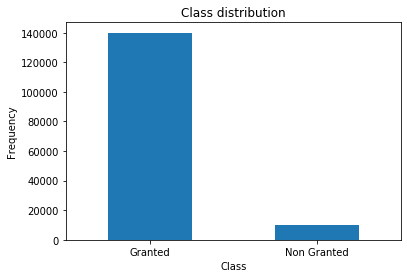

In [31]:
#  Since we have two class of data (Granted and nonGranted clients), let's look at percentage of each class 
All = len(df)
Granted= df[df['SeriousDlqin2yrs'] == 0]
nonGranted = df[df['SeriousDlqin2yrs'] == 1]

x = len(Granted)/All
y = len(nonGranted)/All

print('Granted accounts :',x*100,'%')
print('non Granted accounts :',y*100,'%')

# Plot the clients class against the Frequency
labels = ['Granted','Non Granted']
classes = pd.value_counts(df['SeriousDlqin2yrs'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

**Hint** : Since the data is highly imbalanced, let's look at distribution of each feature in each class to find best strategy to deal with missig values and outliers  

**plot the distribution of features**

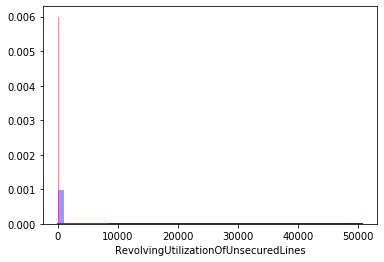

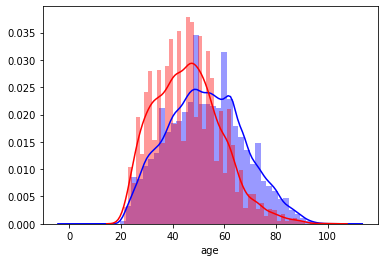

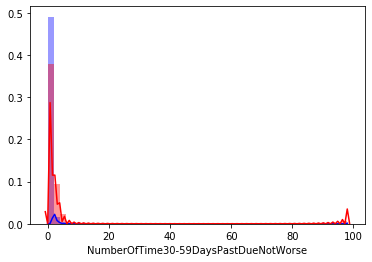

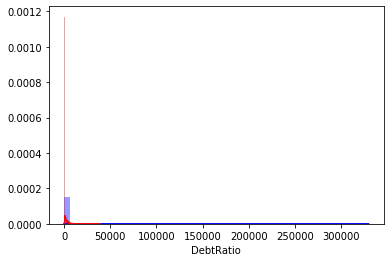

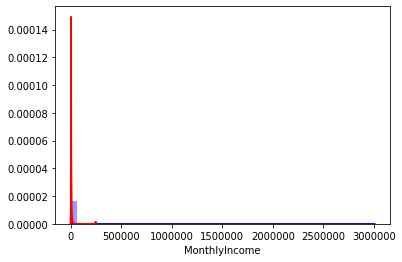

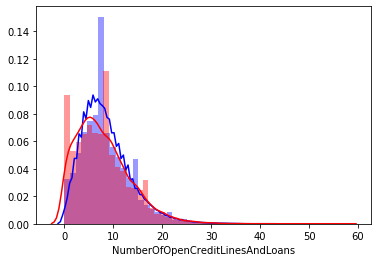

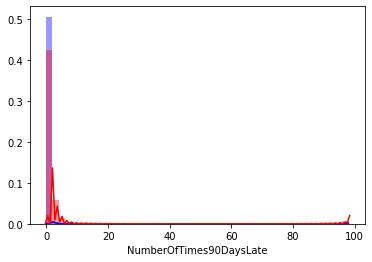

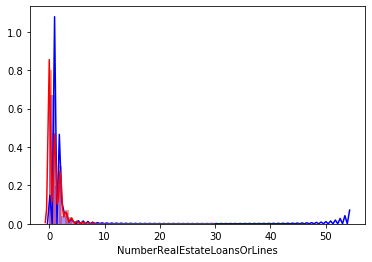

In [32]:
credit_features = df.iloc[:, 2:12].columns
for i in range(2,10):
    cn= credit_features[i-2] 
    plt.figure(i)
    sns.distplot(df[cn][df.SeriousDlqin2yrs == 0], bins=50, color='b')   # Granted Class
    sns.distplot(df[cn][df.SeriousDlqin2yrs == 1], bins=50, color='r')   # Non Granted class
plt.show()

**Preprocessing Strategies for each features**

# 1- *RevolvingUtilizationOfUnsecuredLines* #
has 28 (% 0.02 of data) certain outliers (>10(=%1000!!!), 17 in non Garanted class and 11 in Granted class) that I removed them.  

Number of nan values in training set:  0
Number of nan values in test set:  0
lower level is: -0.46646746396777206 upper_level is: 1.1119838020322277
Number of outliers in training set:  1136


Text(0.5, 1.0, 'test set')

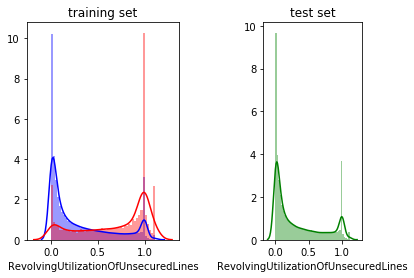

In [33]:
# training set-nan values
nan_values=df['RevolvingUtilizationOfUnsecuredLines'].isna().sum()
print("Number of nan values in training set: ", nan_values )
# remove certain outliers
indexrows = df[ df['RevolvingUtilizationOfUnsecuredLines'] >= 10].index
 # Delete these row indexes from dataFrame
df.drop(indexrows , inplace=True)

# test set-nan values
nan_valuest=df_test['RevolvingUtilizationOfUnsecuredLines'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )
# remove certain outliers in test
indexrowst = df_test[ df_test['RevolvingUtilizationOfUnsecuredLines'] >= 10].index
 # Delete these row indexes from dataFrame
df_test.drop(indexrowst , inplace=True)

# Find other bondaries and outliers in training set
lower_level = df['RevolvingUtilizationOfUnsecuredLines'].mean()-1.5*(np.quantile(df['RevolvingUtilizationOfUnsecuredLines'], .75)-np.quantile(df['RevolvingUtilizationOfUnsecuredLines'], .25))
upper_level = df['RevolvingUtilizationOfUnsecuredLines'].mean()+1.5*(np.quantile(df['RevolvingUtilizationOfUnsecuredLines'], .75)-np.quantile(df['RevolvingUtilizationOfUnsecuredLines'], .25))

print('lower level is:',lower_level, 'upper_level is:',upper_level)
print("Number of outliers in training set: ", sum((df['RevolvingUtilizationOfUnsecuredLines'] < lower_level) | (upper_level < df['RevolvingUtilizationOfUnsecuredLines'])) )

# Replace outliers: As data does not include any outlier less than lower_level and the chance for outlier higher than 
# upper_level to classify as a non Granted is high, I just replace those outlier with higher_level to prevent skweed results 

df.loc[df['RevolvingUtilizationOfUnsecuredLines'] > upper_level, 'RevolvingUtilizationOfUnsecuredLines'] = upper_level
# same method for test set
df_test.loc[df_test['RevolvingUtilizationOfUnsecuredLines'] > upper_level, 'RevolvingUtilizationOfUnsecuredLines'] = upper_level

# plot clean data
plt.subplot(121)
sns.distplot(df['RevolvingUtilizationOfUnsecuredLines'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['RevolvingUtilizationOfUnsecuredLines'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('training set')

plt.subplot(133)
sns.distplot(df_test['RevolvingUtilizationOfUnsecuredLines'], bins=50, color='g')   #test set 
plt.title('test set')

# 2- *Age* #
has 14 outlier (13 data > 100 and 1 data =0) we replace them by mean of age (normal distribution )

Number of nan values in training set:  0
Number of nan values in test set:  0


Text(0.5, 1.0, 'test set')

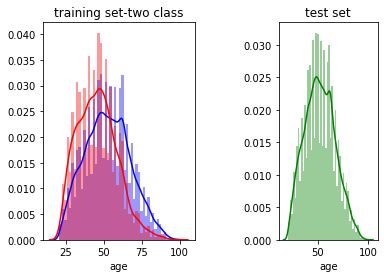

In [34]:
nan_values=df['age'].isna().sum()
print("Number of nan values in training set: ", nan_values )

nan_valuest=df_test['age'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )

df.loc[df['age'] <= 18, 'age'] = df['age'].mean()
df.loc[df['age'] > 100, 'age'] = df['age'].mean()

# apply on test
df_test.loc[df_test['age'] <= 18, 'age'] = df['age'].mean()
df_test.loc[df_test['age'] > 100, 'age'] = df['age'].mean()

# plot clean data
plt.subplot(121)
sns.distplot(df['age'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['age'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('training set-two class')

plt.subplot(133)
sns.distplot(df_test['age'], bins=50, color='g')    # test
plt.title('test set')

# 3- *NumberOfTime30-59DaysPastDueNotWorse* # 
has 269 (%0.2 of data) unreliable data (=98 and 96 others <14). becuase this pattern repeat in two other features ('NumberOfTimes90DaysLate' and 'NumberOfTime60-89DaysPastDueNotWorse') for same data, I remove this data from data set.     

Number of nan values in training set:  0
Number of nan values in test set:  0


Text(0.5, 1.0, 'Test set')

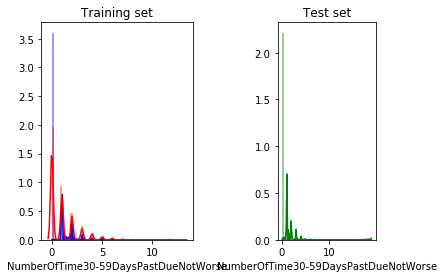

In [35]:
nan_values=df['NumberOfTime30-59DaysPastDueNotWorse'].isna().sum()
print("Number of nan values in training set: ", nan_values )
#test set
nan_valuest=df_test['NumberOfTime30-59DaysPastDueNotWorse'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )

# remove unreliable data
indexrows = df[ df['NumberOfTime30-59DaysPastDueNotWorse'] >= 96 ].index
 # Delete these row indexes from dataFrame
df.drop(indexrows , inplace=True)
#test set
indexrowst = df_test[ df_test['NumberOfTime30-59DaysPastDueNotWorse'] >= 96 ].index
 # Delete these row indexes from dataFrame
df_test.drop(indexrowst , inplace=True)

# plot clean data
plt.subplot(121)
sns.distplot(df['NumberOfTime30-59DaysPastDueNotWorse'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['NumberOfTime30-59DaysPastDueNotWorse'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('Training set')

plt.subplot(133)
sns.distplot(df_test['NumberOfTime30-59DaysPastDueNotWorse'], bins=50, color='g')    #test set
plt.title('Test set')

# 4- *DebtRatio* 

Number of nan values in training set:  0
Number of nan values in test set:  0
Number of outliers (high risk) for Debt Ratio in training set:  35259
Number of outliers (high risk) for Debt Ratio in test set:  23661


count    149490.000000
mean        353.277042
std        2039.982768
min           0.000000
25%           0.175924
50%           0.367093
75%           0.869038
max      329664.000000
Name: DebtRatio, dtype: float64

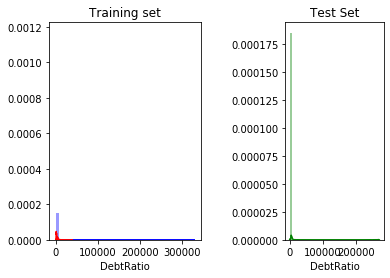

In [36]:
nan_values=df['DebtRatio'].isna().sum()
print("Number of nan values in training set: ", nan_values )

nan_valuest=df_test['DebtRatio'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )

# Find outliers
n=len(df[ df['DebtRatio'] >= 1])
print("Number of outliers (high risk) for Debt Ratio in training set: ", n )
#  As this outliers has higher chance to classify as a non_Granted, I leave them in data   

nt=len(df_test[ df_test['DebtRatio'] >= 1])
print("Number of outliers (high risk) for Debt Ratio in test set: ", nt )

# plot clean data
plt.subplot(121)
sns.distplot(df['DebtRatio'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['DebtRatio'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('Training set')

plt.subplot(133)
sns.distplot(df_test['DebtRatio'], bins=50, color='g')    # test set
plt.title('Test Set')
df['DebtRatio'].describe()

# 5- *MonthlyIncome* #
has 30,000 nan value (%5 of data). I decided to impute them by previous value (other technique like KNN is highly computer cost). 
Outliers replaced by lower_income rate for income less than this rate and by upper_income rate for income higher than upper_income value to prevent skewed results.

Number of nan values in training set:  29542
Number of nan values in test set:  19964
lower_income is: -607.4785938858786 upper_income is: 24142.521406114123
Number of outliers in training set:  1698


Text(0.5, 1.0, 'Test Set')

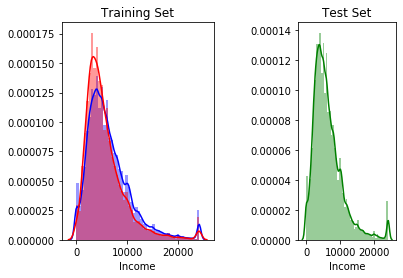

In [37]:
nan_values=df['MonthlyIncome'].isna().sum()
print("Number of nan values in training set: ", nan_values )
df['Income']=df['MonthlyIncome'].fillna(method='ffill', inplace=False)
#nan_values2=df['Income'].isna().sum()
#print("Number of nan values in new column in train: ", nan_values2 )

# test set
nan_valuest=df_test['MonthlyIncome'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )
df_test['Income']=df_test['MonthlyIncome'].fillna(method='ffill', inplace=False)
#nan_values2t=df_test['Income'].isna().sum()
#print("Number of nan values in new column in test: ", nan_values2t )

# find outliers
lower_income = df['Income'].mean()-1.5*(np.quantile(df['Income'], .75)-np.quantile(df['Income'], .25))
upper_income = df['Income'].mean()+1.5*(np.quantile(df['Income'], .75)+np.quantile(df['Income'], .25))

print('lower_income is:',lower_income, 'upper_income is:',upper_income)
print("Number of outliers in training set: ", sum((df['Income'] < lower_income) | (upper_income < df['Income'])) )

# replace outlier 
#df.loc[df['Income'] < lower_income, 'Income'] = lower_income
df.loc[df['Income'] > upper_income, 'Income'] = upper_income
#test set
df_test.loc[df_test['Income'] > upper_income, 'Income'] = upper_income

# plot clean data
plt.subplot(121)
sns.distplot(df['Income'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['Income'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('Training Set')


plt.subplot(133)
sns.distplot(df_test['Income'], bins=50, color='g')    # test
plt.title('Test Set')

# second impute method 
#from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=2, weights="uniform")
#df['Income']= imputer.fit_transform(df[['MonthlyIncome']])


#6- *NumberOfOpenCreditLinesAndLoans*#



Number of nan values in training:  0
Number of nan values in test set:  0
lower_level is: -0.5277075389658172 upper_level is: 32.472292461034186
Number of outliers in training set:  228


Text(0.5, 1.0, 'Test Set')

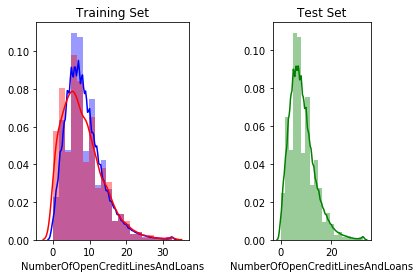

In [38]:
nan_values=df['NumberOfOpenCreditLinesAndLoans'].isna().sum()
print("Number of nan values in training: ", nan_values )
#n=len(df['NumberOfOpenCreditLinesAndLoans'])

nan_valuest=df_test['NumberOfOpenCreditLinesAndLoans'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )

# find outliers
lower_level = df['NumberOfOpenCreditLinesAndLoans'].mean()-1.5*(np.quantile(df['NumberOfOpenCreditLinesAndLoans'], .75)-np.quantile(df['NumberOfOpenCreditLinesAndLoans'], .25))
upper_level = df['NumberOfOpenCreditLinesAndLoans'].mean()+1.5*(np.quantile(df['NumberOfOpenCreditLinesAndLoans'], .75)+np.quantile(df['NumberOfOpenCreditLinesAndLoans'], .25))

print('lower_level is:',lower_level, 'upper_level is:',upper_level)
print("Number of outliers in training set: ", sum((df['NumberOfOpenCreditLinesAndLoans'] < lower_level) | (upper_level < df['NumberOfOpenCreditLinesAndLoans'])) )
#print("total data: ", n )

# replace outlier with lower_level and upper_level
df.loc[df['NumberOfOpenCreditLinesAndLoans'] < lower_level, 'NumberOfOpenCreditLinesAndLoans'] = lower_level
df.loc[df['NumberOfOpenCreditLinesAndLoans'] > upper_level, 'NumberOfOpenCreditLinesAndLoans'] = upper_level

df_test.loc[df_test['NumberOfOpenCreditLinesAndLoans'] < lower_level, 'NumberOfOpenCreditLinesAndLoans'] = lower_level
df_test.loc[df_test['NumberOfOpenCreditLinesAndLoans'] > upper_level, 'NumberOfOpenCreditLinesAndLoans'] = upper_level


# plot clean data
plt.subplot(121)
sns.distplot(df['NumberOfOpenCreditLinesAndLoans'][df.SeriousDlqin2yrs == 0], bins=20, color='b')    # Granted class
sns.distplot(df['NumberOfOpenCreditLinesAndLoans'][df.SeriousDlqin2yrs == 1], bins=20, color='r')    #Non Granted class
plt.title('Training Set')

plt.subplot(133)
sns.distplot(df_test['NumberOfOpenCreditLinesAndLoans'], bins=20, color='g')    # Test Set
plt.title('Test Set')

# 7- *NumberOfTimes90DaysLate*#
More than %90 of data is zero.

Number of nan values in training set:  0
Number of nan values in test set:  0


Text(0.5, 1.0, 'Test Set')

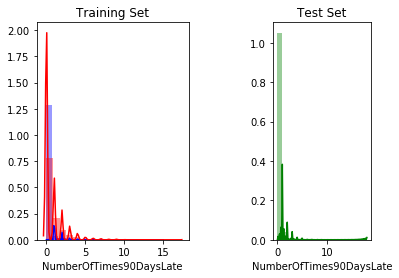

In [39]:
nan_values=df['NumberOfTimes90DaysLate'].isna().sum()
print("Number of nan values in training set: ", nan_values )

nan_valuest=df_test['NumberOfTimes90DaysLate'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )
# plot clean data
plt.subplot(121)
sns.distplot(df['NumberOfTimes90DaysLate'][df.SeriousDlqin2yrs == 0], bins=20, color='b')    # Granted class
sns.distplot(df['NumberOfTimes90DaysLate'][df.SeriousDlqin2yrs == 1], bins=20, color='r')    #Non Granted class
plt.title('Training Set')

plt.subplot(133)
sns.distplot(df_test['NumberOfTimes90DaysLate'], bins=20, color='g')    # Test set
plt.title('Test Set')

#8- *NumberRealEstateLoansOrLines*





Number of nan values in training:  0
Number of nan values in test set:  0
lower_level is: -1.980199344437755 upper_level is: 4.0198006555622445
Number of outliers in training set:  1479


Text(0.5, 1.0, 'Test Set')

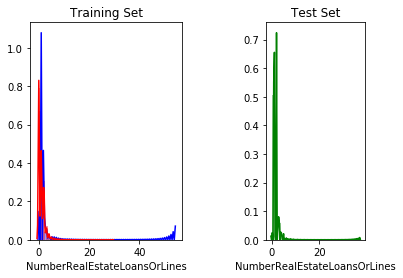

In [40]:
nan_values=df['NumberRealEstateLoansOrLines'].isna().sum()
print("Number of nan values in training: ", nan_values )

nan_valuest=df_test['NumberRealEstateLoansOrLines'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )

lower_level = df['NumberRealEstateLoansOrLines'].mean()-1.5*(np.quantile(df['NumberRealEstateLoansOrLines'], .75)-np.quantile(df['NumberRealEstateLoansOrLines'], .25))
upper_level = df['NumberRealEstateLoansOrLines'].mean()+1.5*(np.quantile(df['NumberRealEstateLoansOrLines'], .75)-np.quantile(df['NumberRealEstateLoansOrLines'], .25))

print('lower_level is:',lower_level, 'upper_level is:',upper_level)
print("Number of outliers in training set: ", sum((df['NumberRealEstateLoansOrLines'] < lower_level) | (upper_level < df['NumberRealEstateLoansOrLines'])) )

# Outliers are important for this feature, I just leave them becuase they are not big portion of data 

# plot clean data
plt.subplot(121)
sns.distplot(df['NumberRealEstateLoansOrLines'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['NumberRealEstateLoansOrLines'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('Training Set')

plt.subplot(133)
sns.distplot(df_test['NumberRealEstateLoansOrLines'], bins=50, color='g')    # Granted class
plt.title('Test Set')


#9- *NumberOfTime60-89DaysPastDueNotWorse*#

Number of nan values in training set:  0
Number of nan values in test set:  0


Text(0.5, 1.0, 'Test Set')

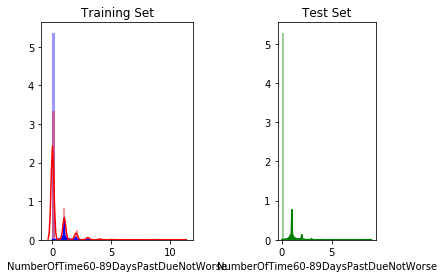

In [41]:
nan_values=df['NumberOfTime60-89DaysPastDueNotWorse'].isna().sum()
print("Number of nan values in training set: ", nan_values )

nan_valuest=df_test['NumberOfTime60-89DaysPastDueNotWorse'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )

# plot clean data
plt.subplot(121)
sns.distplot(df['NumberOfTime60-89DaysPastDueNotWorse'][df.SeriousDlqin2yrs == 0], bins=50, color='b')    # Granted class
sns.distplot(df['NumberOfTime60-89DaysPastDueNotWorse'][df.SeriousDlqin2yrs == 1], bins=50, color='r')    #Non Granted class
plt.title('Training Set')

plt.subplot(133)
sns.distplot(df_test['NumberOfTime60-89DaysPastDueNotWorse'], bins=50, color='g')    # Test set
plt.title('Test Set')

#10-*NumberOfDependents*#

Number of nan values in training set:  3880
Number of nan values in test set:  2599
lower_level is: -0.7420161883738042 upper_level is: 2.257983811626196
Number of outliers:  13652


Text(0.5, 1.0, 'Test Set')

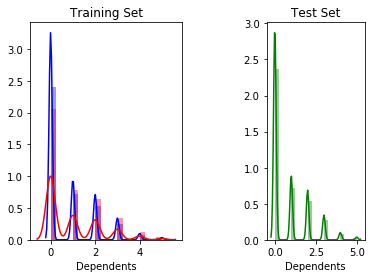

In [42]:
nan_values=df['NumberOfDependents'].isna().sum()
print("Number of nan values in training set: ", nan_values )

nan_valuest=df_test['NumberOfDependents'].isna().sum()
print("Number of nan values in test set: ", nan_valuest )


# replace nan values by forward filling method

df['Dependents']=df['NumberOfDependents'].fillna(method='ffill', inplace=False)
#nan_values2=df['Dependents'].isna().sum()
#print("Number of nan values in new column in training set: ", nan_values2 )

df_test['Dependents']=df_test['NumberOfDependents'].fillna(method='ffill', inplace=False)
#nan_values2t=df_test['Dependents'].isna().sum()
#print("Number of nan values in new column in test set: ", nan_values2t )

# outliers
lower_level = df['Dependents'].mean()-1.5*(np.quantile(df['Dependents'], .75)-np.quantile(df['Dependents'], .25))
upper_level = df['Dependents'].mean()+1.5*(np.quantile(df['Dependents'], .75)-np.quantile(df['Dependents'], .25))

print('lower_level is:',lower_level, 'upper_level is:',upper_level)
print("Number of outliers: ", sum((df['Dependents'] < lower_level) | (upper_level < df['Dependents'])) )

# based on distribution of data and above results, I consider data>5 as a outliers and replace by 5 (totaly 900 (%0.6 of data))  
df.loc[df['Dependents'] >5, 'Dependents'] =5
df_test.loc[df_test['Dependents'] >5, 'Dependents'] =5

# plot clean data
plt.subplot(121)
sns.distplot(df['Dependents'][df.SeriousDlqin2yrs == 0], bins=20, color='b')    # Granted class
sns.distplot(df['Dependents'][df.SeriousDlqin2yrs == 1], bins=20, color='r')    #Non Granted class
plt.title('Training Set')
df['Dependents'].describe()


plt.subplot(133)
sns.distplot(df_test['Dependents'], bins=20, color='g')    # test set
plt.title('Test Set')

In [0]:
# Save files
df_train=df.drop(['MonthlyIncome','NumberOfDependents'], axis=1)
df_train.describe()
path=r'Training_Set.xlsx'
writer=pd.ExcelWriter(path)
df_train.to_excel(writer, index=False)
writer.save()

df_test2=df_test.drop(['MonthlyIncome','NumberOfDependents'], axis=1)
path=r'Test_Set.xlsx'
writer=pd.ExcelWriter(path)
df_test2.to_excel(writer, index=False)
writer.save()